goal: train 10 machine learning predictors: one predictor for each function from the ten protein function categories ("DNA, RNA and nucleotide metabolism", "tail", "head and packaging", "other", "lysis", "connector", "transcription regulation", "moron, auxiliary metabolic gene and host takeover", "unknown function", "integration and excision") 

predictor input: protein features; output: labels (0/1) representing whether the protein serves the specific function

dataset: 360,413 seqs in total - 60% for training, 20% for validation, 20% for testing
-use clustering results to avoid spliting protein seqs in the same cluster (maybe use GroupShuffleSplit from sklearn)

features: 1711-dim

dataset:  
2,318,538 seqs in the original dataset  
927,040 seqs after dropping pcat "unknown_no_hit"  
360,413 unique seqs after dropping duplicated seqs  

In [1]:
import pandas as pd

# data preparation

In [17]:
def add_label(features, ids):
    features["label"] = features["id"].isin(ids["name"]).astype(int)
    features = features.drop(columns=["md5"])
    return features

In [2]:
features = pd.read_parquet("../dataset/protein_features_unique.pa")
tail_ids = pd.read_csv("../dataset/pcat/tail.csv")

In [18]:
features_tail = add_label(features, tail_ids)

In [19]:
features_tail["label"].value_counts()

label
0    286131
1     74282
Name: count, dtype: int64

# training script

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, Any
import joblib
import os
import json

In [48]:
def prepare_data(
    df: pd.DataFrame,
    feature_cols: list,
    cluster_mapping: Dict[str, str],
    label_col: str = "label",
    id_col: str = "id",
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Prepare data for training by separating features and labels.

    Args:
        df: DataFrame containing features and labels
        feature_cols: List of feature column names
        cluster_mapping: Dictionary mapping sequence IDs to cluster IDs
        label_col: Name of the label column
        id_col: Name of the ID column

    Returns:
        X: Feature matrix
        y: Label array
        ids: Array of sequence IDs
        groups: Array of cluster IDs for each sequence
    """
    X = df[feature_cols].values
    y = df[label_col].values
    ids = df[id_col].values

    # Get cluster IDs for each sequence
    groups = np.array([cluster_mapping.get(str(id_), "unknown") for id_ in ids])

    return X, y, ids, groups

In [49]:
def split_data(
    X: np.ndarray,
    y: np.ndarray,
    ids: np.ndarray,
    groups: np.ndarray,
    test_size: float = 0.2,
    val_size: float = 0.2,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Split data into train, validation, and test sets while keeping related sequences together.

    Args:
        X: Feature matrix
        y: Label array
        ids: Array of sequence IDs
        groups: Array of cluster IDs for each sequence
        test_size: Proportion of data to use for testing
        val_size: Proportion of data to use for validation
    """
    # First split: separate test set
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_val_idx, test_idx = next(gss.split(X, y, groups=groups))

    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val = groups[train_val_idx]

    # Second split: separate validation set from training set
    val_size_adjusted = val_size / (
        1 - test_size
    )  # Adjust val_size to account for test set
    gss = GroupShuffleSplit(n_splits=1, test_size=val_size_adjusted, random_state=42)
    train_idx, val_idx = next(
        gss.split(X_train_val, y_train_val, groups=groups_train_val)
    )

    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [50]:
def train_model(
    X_train: np.ndarray, y_train: np.ndarray, model_params: Dict[str, Any] = None
) -> Tuple[Any, StandardScaler]:
    """Train an XGBoost classifier with optional hyperparameters."""
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Set default parameters if none provided
    if model_params is None:
        model_params = {
            "n_estimators": 200,
            "max_depth": 6,
            "learning_rate": 0.1,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "min_child_weight": 1,
            "scale_pos_weight": 1,  # Will be adjusted based on class imbalance
            "random_state": 42,
        }

    # Calculate scale_pos_weight based on class imbalance
    n_neg = np.sum(y_train == 0)
    n_pos = np.sum(y_train == 1)
    model_params["scale_pos_weight"] = n_neg / n_pos

    # Train model
    model = XGBClassifier(**model_params)
    model.fit(
        X_train_scaled, y_train, eval_set=[(X_train_scaled, y_train)], verbose=False
    )

    return model, scaler

In [51]:
def evaluate_model(
    model: Any,
    scaler: StandardScaler,
    X: np.ndarray,
    y: np.ndarray,
    set_name: str = "",
    threshold: float = 0.5,
) -> Dict[str, float]:
    """Evaluate model performance on a dataset."""
    X_scaled = scaler.transform(X)
    y_pred_proba = model.predict_proba(X_scaled)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)

    metrics = {
        f"{set_name}_accuracy": accuracy_score(y, y_pred),
        f"{set_name}_precision": precision_score(y, y_pred),
        f"{set_name}_recall": recall_score(y, y_pred),
        f"{set_name}_f1": f1_score(y, y_pred),
        f"{set_name}_roc_auc": roc_auc_score(y, y_pred_proba),
    }

    # Print metrics first
    print(f"\nMetrics for {set_name} (threshold={threshold}):")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Then show plots
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {set_name} (threshold={threshold})")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    return metrics

In [52]:
def plot_feature_importance(model: Any, feature_cols: list, top_n: int = 20):
    """Plot feature importance from XGBoost model."""
    importance_scores = model.feature_importances_
    indices = np.argsort(importance_scores)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(top_n), importance_scores[indices[:top_n]])
    plt.xticks(range(top_n), [feature_cols[i] for i in indices[:top_n]], rotation=90)
    plt.tight_layout()
    plt.show()

    # Print top N most important features
    print(f"\nTop {top_n} most important features:")
    for i in range(top_n):
        print(f"{feature_cols[indices[i]]}: {importance_scores[indices[i]]:.4f}")

In [44]:
def save_model(
    model: Any, scaler: StandardScaler, feature_cols: list, function_name: str
):
    """Save the trained model and scaler."""
    # Create models directory if it doesn't exist
    os.makedirs("../models", exist_ok=True)

    # Create a dictionary containing all necessary components
    model_data = {"model": model, "scaler": scaler, "feature_cols": feature_cols}

    # Save the model data
    joblib.dump(model_data, f"../models/{function_name}_predictor.joblib")

In [55]:
def train_function_predictor(
    df: pd.DataFrame, function_name: str, model_params: Dict[str, Any] = None
):
    """Main training pipeline for a specific protein function."""
    # Load cluster mapping
    with open("../dataset/protein_cluster_mapping.json", "r") as f:
        cluster_mapping = json.load(f)

    # Get feature columns (excluding 'id' and 'label')
    feature_cols = [col for col in df.columns if col not in ["id", "label"]]

    # Prepare data
    X, y, ids, groups = prepare_data(df, feature_cols, cluster_mapping)

    # Split data
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, ids, groups)

    # Train model
    model, scaler = train_model(X_train, y_train, model_params)

    # Plot feature importance
    plot_feature_importance(model, feature_cols)

    # Evaluate model on all sets
    print("\n=== Training Set ===")
    train_metrics = evaluate_model(model, scaler, X_train, y_train, "train")

    print("\n=== Validation Set ===")
    val_metrics = evaluate_model(model, scaler, X_val, y_val, "val")

    print("\n=== Test Set ===")
    # Calculate metrics for all thresholds
    thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
    for threshold in thresholds:
        if threshold == 0.5:
            # For threshold 0.5, show both metrics and plot
            test_metrics = evaluate_model(
                model, scaler, X_test, y_test, "test", threshold
            )
        else:
            # For other thresholds, only calculate and show metrics
            X_scaled = scaler.transform(X_test)
            y_pred_proba = model.predict_proba(X_scaled)[:, 1]
            y_pred = (y_pred_proba >= threshold).astype(int)

            metrics = {
                f"test_accuracy": accuracy_score(y_test, y_pred),
                f"test_precision": precision_score(y_test, y_pred),
                f"test_recall": recall_score(y_test, y_pred),
                f"test_f1": f1_score(y_test, y_pred),
                f"test_roc_auc": roc_auc_score(y_test, y_pred_proba),
            }

            print(f"\nTest Metrics (threshold={threshold}):")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")

    # Save model
    save_model(model, scaler, feature_cols, function_name)

# execution

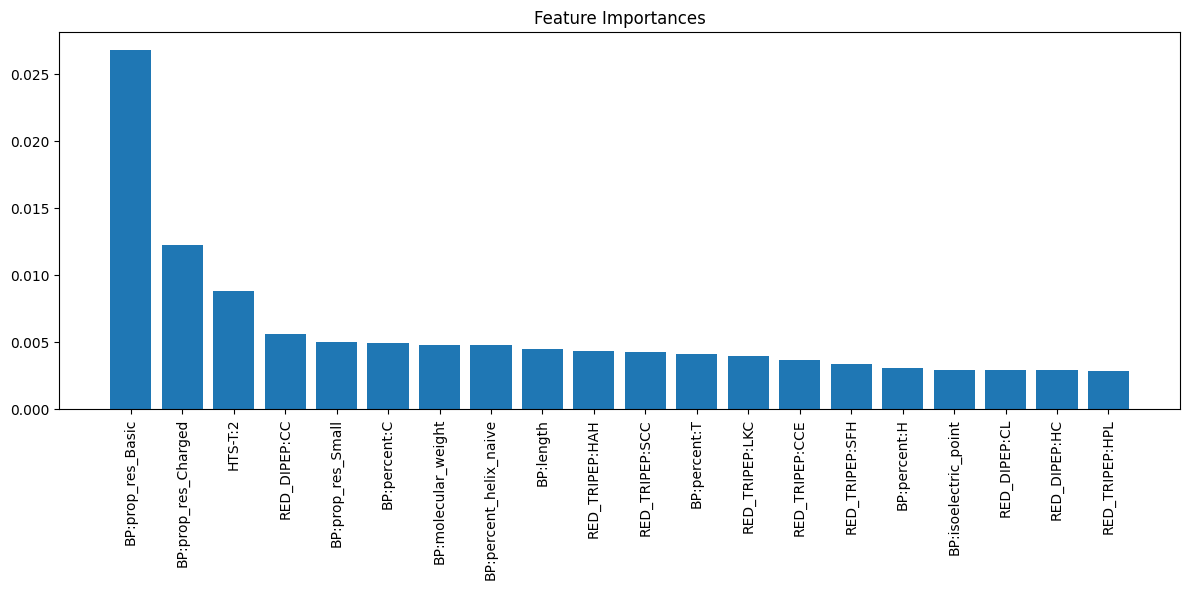


Top 20 most important features:
BP:prop_res_Basic: 0.0268
BP:prop_res_Charged: 0.0123
HTS-T:2: 0.0088
RED_DIPEP:CC: 0.0056
BP:prop_res_Small: 0.0050
BP:percent:C: 0.0049
BP:molecular_weight: 0.0048
BP:percent_helix_naive: 0.0048
BP:length: 0.0045
RED_TRIPEP:HAH: 0.0043
RED_TRIPEP:SCC: 0.0043
BP:percent:T: 0.0041
RED_TRIPEP:LKC: 0.0040
RED_TRIPEP:CCE: 0.0037
RED_TRIPEP:SFH: 0.0034
BP:percent:H: 0.0031
BP:isoelectric_point: 0.0030
RED_DIPEP:CL: 0.0029
RED_DIPEP:HC: 0.0029
RED_TRIPEP:HPL: 0.0028

=== Training Set ===

Metrics for train (threshold=0.5):
train_accuracy: 0.9880
train_precision: 0.9496
train_recall: 0.9923
train_f1: 0.9705
train_roc_auc: 0.9993


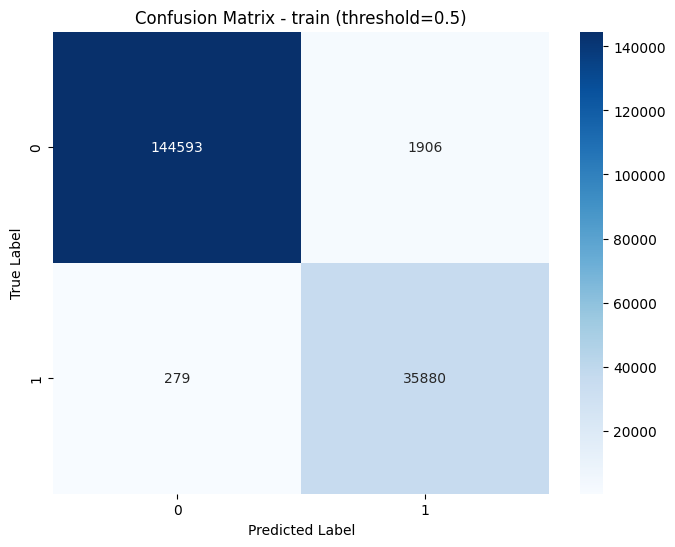


=== Validation Set ===

Metrics for val (threshold=0.5):
val_accuracy: 0.8902
val_precision: 0.7647
val_recall: 0.7830
val_f1: 0.7737
val_roc_auc: 0.9258


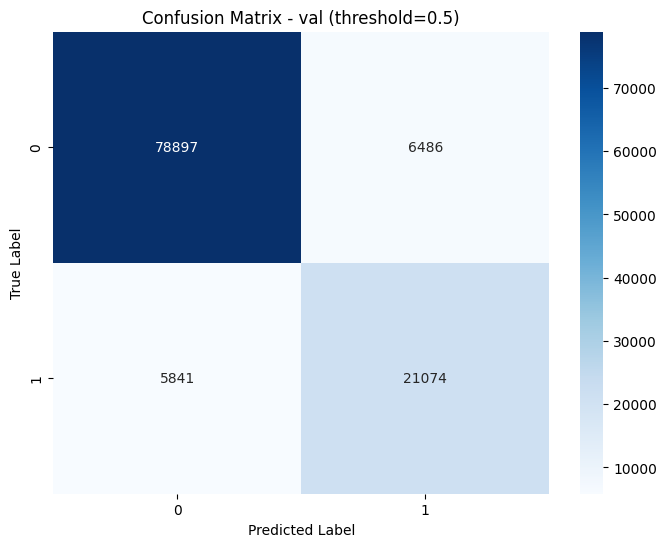


=== Test Set ===

Test Metrics (threshold=0.3):
test_accuracy: 0.8339
test_precision: 0.5097
test_recall: 0.7810
test_f1: 0.6169
test_roc_auc: 0.8786

Test Metrics (threshold=0.4):
test_accuracy: 0.8552
test_precision: 0.5603
test_recall: 0.7159
test_f1: 0.6286
test_roc_auc: 0.8786

Metrics for test (threshold=0.5):
test_accuracy: 0.8681
test_precision: 0.6061
test_recall: 0.6556
test_f1: 0.6299
test_roc_auc: 0.8786


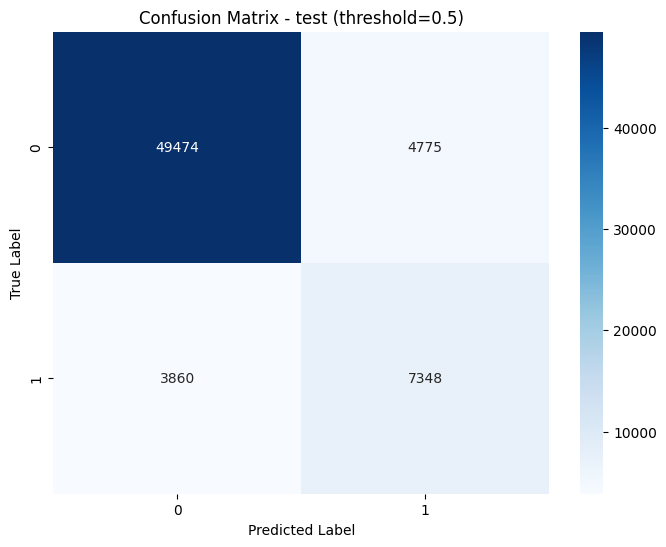


Test Metrics (threshold=0.6):
test_accuracy: 0.8764
test_precision: 0.6529
test_recall: 0.5945
test_f1: 0.6223
test_roc_auc: 0.8786

Test Metrics (threshold=0.7):
test_accuracy: 0.8800
test_precision: 0.6995
test_recall: 0.5242
test_f1: 0.5993
test_roc_auc: 0.8786


In [56]:
model_params = {
    "n_estimators": 300,  # Increase from 200
    "max_depth": 8,  # Increase from 6
    "learning_rate": 0.05,  # Decrease from 0.1
    "subsample": 0.7,  # Decrease from 0.8
    "colsample_bytree": 0.7,  # Decrease from 0.8
    "min_child_weight": 2,  # Increase from 1
    "random_state": 42,
}

# Train the predictor for the "tail" function
train_function_predictor(features_tail, "tail", model_params)

ROC AUC: Receiver Operating Characteristic Area Under the Curve  
Accuracy = (True Positives + True Negatives) / Total Predictions  
Precision = True Positives / (True Positives + False Positives)  
Recall = True Positives / (True Positives + False Negatives)  
F1 = 2 * (Precision * Recall) / (Precision + Recall)